In [1]:
from spyglass.common import Session
from spyglass_hexmaze.hex_maze_behavior import HexMazeBlock, HexMazeChoice
import pandas as pd

# Join HexMazeChoice with a bunch of other tables
# We need the Session table for session_id and subject_id
# We need HexMazeBlock and Trial for opto_cond and session_type
df = pd.DataFrame(
    (HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True)
)

subject_id = "Toby"
df = df[df["subject_id"] == subject_id]
df = df[df["task_type"] == "probability change"]
# df = df[df["session_description"]=="ThetaStimLatePhase"]
# df = df[df["opto_cond"]!="no_delay"]

# Binary dependent variable
df["choose_left"] = (df["choice_direction"] == "left").astype(int)

# Open question: in Tim's paper, random effects were estimated over the levels of rat and session-within-rat.
# For Berke Lab, we only have one session (epoch) per day. BUT for Frank lab, we have multiple epochs per session.
# Do we want to estimate random effects over the level of epoch_id instead of (or in addition to??), session_id?
df["epoch_id"] = df["session_id"].astype(str) + "_epoch" + df["epoch"].astype(str)

# Keep only columns useful for regression
regression_cols = [
    "subject_id",  # random effect
    "session_id",  # nested grouping/random effect
    "epoch_id",  # nested grouping/random effect
    "session_description",  # we may want to filter based on opto sessions (Frank Lab)
    "opto_cond",  # we may want to filter based on opto condition to see effects here
    "task_type",  # we may want to filter based on `probability change` vs `barrier change`
    "block",  # we may want to filter based on block?
    "block_trial_num",  # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "choose_left",  # binary dependent variable
    "reward_prob_diff",  # predictor
    "path_length_diff",  # predictor
]
regression_df = df[regression_cols].copy()

# Convert all non-numeric columns to 'category' dtype
for col in regression_df.columns:
    if not pd.api.types.is_numeric_dtype(regression_df[col]):
        regression_df[col] = regression_df[col].astype("str")

display(regression_df)

/home/scrater/miniforge3/envs/spyglass/lib/python3.10/site-packages/datajoint/plugin.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-12-05 20:43:41,377][INFO]: DataJoint 0.14.6 connected to scrater@lmf-db.cin.ucsf.edu:3306


,subject_id,session_id,epoch_id,session_description,opto_cond,task_type,block,block_trial_num,choose_left,reward_prob_diff,path_length_diff
7074,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,2,0,-80.0,0
7075,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,3,1,-40.0,2
7076,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,4,1,80.0,0
7077,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,5,1,-40.0,-2
7078,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,6,1,-40.0,2
...,...,...,...,...,...,...,...,...,...,...,...
22201,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,65,1,80.0,4
22202,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,66,0,40.0,4
22203,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,67,1,80.0,4
22204,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,68,0,40.0,4


### Scale data and do the regression

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

base = importr("base")
lme4 = importr("lme4")

# Extra save name so we don't keep overwriting
name = subject_id

# Create output directory if it doesn't exist so R doesn't get mad
import os

os.makedirs("regression_output", exist_ok=True)

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[["reward_prob_diff_scaled", "path_length_diff_scaled"]] = (
    scaler.fit_transform(regression_df[["reward_prob_diff", "path_length_diff"]])
)

# Subset trials (maybe > 25?) to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df["block_trial_num"] > 20].copy()

# Convert df to R
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign("df_r", r_df)

# Do mixed-effects regression in R
r(
    """
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | epoch_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
"""
)

# Print model summary
print("model summary")
print(r("summary(model)"))

# Get fixed effects and random effects by epoch
r(
    f"""
# Extract fixed effects
# This is the average effect across all epochs

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by epoch
# This is the complete coefficients for each epoch (fixed effect + this epoch's deviation)

ranef_by_epoch <- as.data.frame(coef(model)$epoch_id)
ranef_by_epoch$epoch_id <- rownames(ranef_by_epoch)
write.csv(ranef_by_epoch, "regression_output/effects_by_epoch_{name}.csv", row.names = FALSE)
"""
)

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_epoch = pd.read_csv(f"regression_output/effects_by_epoch_{name}.csv")

display(fixed_effects)
display(effects_by_epoch)

model summary
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |          epoch_id)
   Data: df_r
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
   7003.8    7062.9   -3492.9    6985.8      5247 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2869 -0.9183 -0.3038  0.9202  2.9843 

Random effects:
 Groups   Name                    Variance Std.Dev. Corr       
 epoch_id (Intercept)             1.441    1.200               
          reward_prob_diff_scaled 1.939    1.392    -0.34      
          path_length_diff_scaled 7.635    2.763    -0.55 -0.58
Number of obs: 5256, groups:  epoch_id, 36

Fixed effects:
                        Estimate Std. Error z value Pr(>|z|)
(Intercept)              -0.1562     0.2200  -0.71

,Estimate,Std. Error,z value,Pr(>|z|),term
0,-0.156224,0.219960,-0.710235,0.477558,(Intercept)
1,0.298985,0.255856,1.168567,0.242578,reward_prob_diff_scaled
2,-0.205827,0.485113,-0.424286,0.671357,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,epoch_id
0,0.987317,-0.444388,-0.379713,Toby_20250310_epoch1
1,1.601175,-2.483718,1.405130,Toby_20250310_epoch3
2,-0.240465,-0.324518,1.706648,Toby_20250310_epoch5
3,-0.657193,0.631601,0.364041,Toby_20250311_epoch1
4,-0.751733,1.948624,-2.164175,Toby_20250311_epoch3
5,-0.198975,0.020242,1.188250,Toby_20250312_epoch1
6,0.460696,0.474575,-1.535384,Toby_20250312_epoch3
7,-0.380732,2.225158,-3.301985,Toby_20250313_epoch1
8,-0.338618,-2.028790,4.845821,Toby_20250313_epoch5
9,-0.638537,1.347587,-0.723558,Toby_20250314_epoch1


### Plot the regression coefficients 

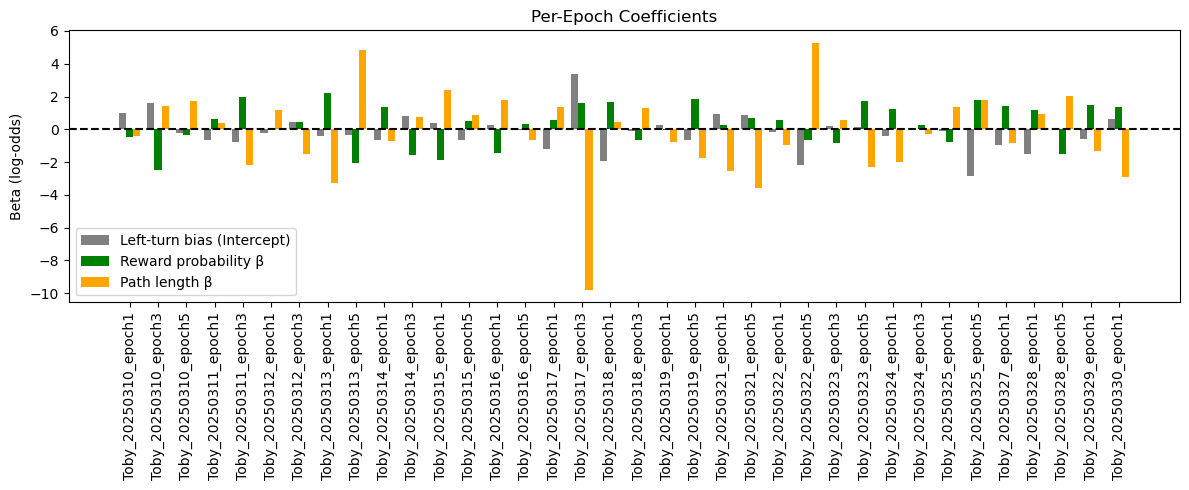

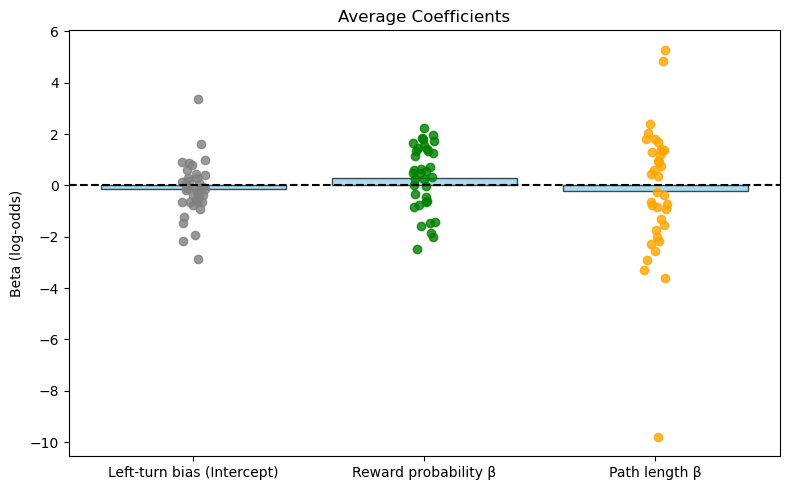

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Coefs to plot
coeffs = ["(Intercept)", "reward_prob_diff_scaled", "path_length_diff_scaled"]
labels = ["Left-turn bias (Intercept)", "Reward probability β", "Path length β"]
colors = ["grey", "green", "orange"]

# Plot bar graph of turn bias, reward beta, and path length beta for each epoch
effects_by_epoch = effects_by_epoch.sort_values("epoch_id")

x = np.arange(len(effects_by_epoch))
w = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - w, effects_by_epoch[coeffs[0]], w, color=colors[0], label=labels[0])
plt.bar(x, effects_by_epoch[coeffs[1]], w, color=colors[1], label=labels[1])
plt.bar(x + w, effects_by_epoch[coeffs[2]], w, color=colors[2], label=labels[2])
plt.axhline(0, color="black", ls="--")
plt.xticks(x, effects_by_epoch["epoch_id"], rotation=90)
plt.ylabel("Beta (log-odds)")
plt.title("Per-Epoch Coefficients")
plt.legend()
plt.tight_layout()
plt.show()

# Now plot average turn bias, reward beta, and path length beta (with dots showing values by epoch)
means = effects_by_epoch[coeffs].mean()
x = np.arange(len(coeffs))

plt.figure(figsize=(8, 5))
plt.bar(x, means, color="skyblue", edgecolor="k", alpha=0.7)
for i, (coef, col) in enumerate(zip(coeffs, colors)):
    jitter = (np.random.rand(len(effects_by_epoch)) - 0.5) * 0.1
    plt.scatter(
        np.full(len(effects_by_epoch), x[i]) + jitter,
        effects_by_epoch[coef],
        color=col,
        alpha=0.8,
    )
plt.xticks(x, labels)
plt.axhline(0, color="black", ls="--")
plt.ylabel("Beta (log-odds)")
plt.title("Average Coefficients")
plt.tight_layout()
plt.show()

### Plot some histograms as a sanity check

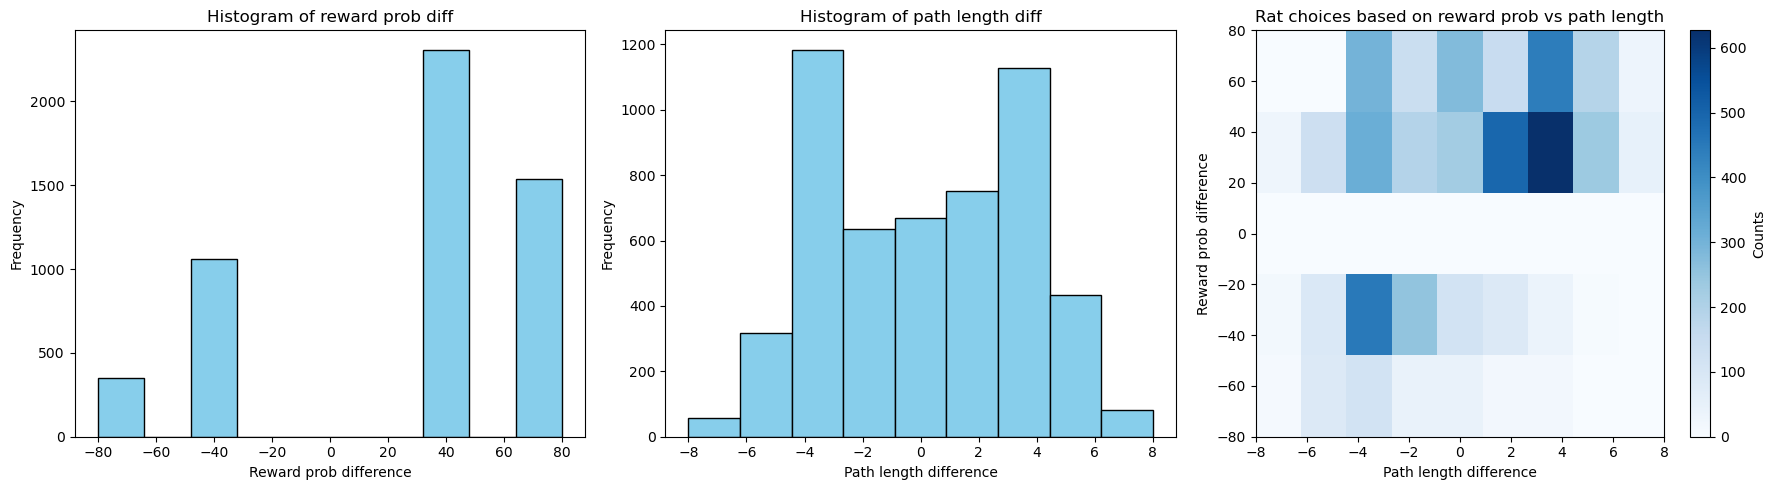

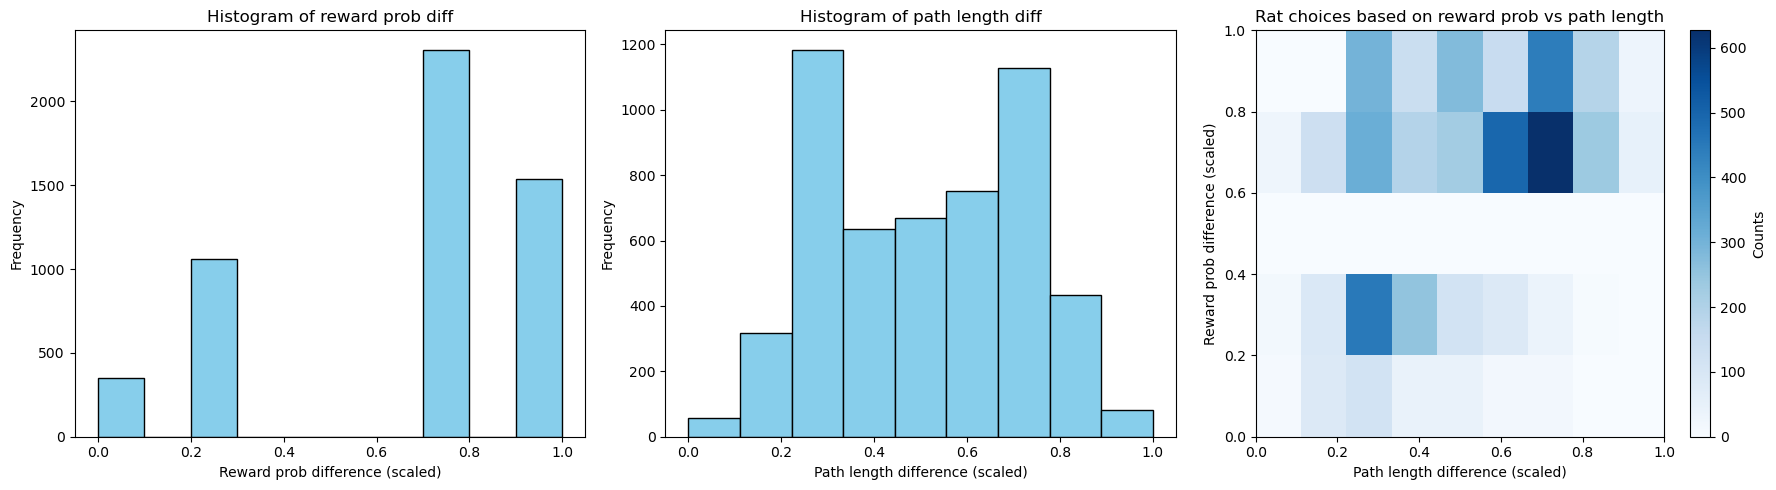

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter if we want (do the same filtering as you did for the regression)
small_df = regression_df[
    regression_df["block_trial_num"] > 20
]  # [regression_df["epoch_id"]== "Toby_20250318_epoch3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of reward prob diff
axes[0].hist(small_df["reward_prob_diff"], color="skyblue", edgecolor="black")
axes[0].set_xlabel("Reward prob difference")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of reward prob diff")

# Histogram of path length diff
axes[1].hist(small_df["path_length_diff"], bins=9, color="skyblue", edgecolor="black")
axes[1].set_xlabel("Path length difference")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of path length diff")

# Histogram of both
h = axes[2].hist2d(
    small_df["path_length_diff"],
    small_df["reward_prob_diff"],
    bins=[9, 5],
    cmap="Blues",
)
fig.colorbar(h[3], ax=axes[2], label="Counts")
axes[2].set_xlabel("Path length difference")
axes[2].set_ylabel("Reward prob difference")
axes[2].set_title("Rat choices based on reward prob vs path length")

plt.tight_layout()
plt.show()

# Again, but scaled to prove our scaling works!!
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of reward prob diff
axes[0].hist(small_df["reward_prob_diff_scaled"], color="skyblue", edgecolor="black")
axes[0].set_xlabel("Reward prob difference (scaled)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of reward prob diff")

# Histogram of path length diff
axes[1].hist(
    small_df["path_length_diff_scaled"], bins=9, color="skyblue", edgecolor="black"
)
axes[1].set_xlabel("Path length difference (scaled)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of path length diff")

# Histogram of both
h = axes[2].hist2d(
    small_df["path_length_diff_scaled"],
    small_df["reward_prob_diff_scaled"],
    bins=[9, 5],
    cmap="Blues",
)
fig.colorbar(h[3], ax=axes[2], label="Counts")
axes[2].set_xlabel("Path length difference (scaled)")
axes[2].set_ylabel("Reward prob difference (scaled)")
axes[2].set_title("Rat choices based on reward prob vs path length")

plt.tight_layout()
plt.show()

--------------------

## Collinearity?

OK it looks like Xulu designed the task such that longer paths are correlated woth higher reward probs (90/50 path is never the shortest and often the longest). Visualize it. More histograms!

,path_length,avg_path_prob
0,19,50.0
1,21,30.0
2,21,70.0
3,19,50.0
4,21,70.0
...,...,...
802,21,70.0
803,17,30.0
804,17,50.0
805,21,70.0


,path_length_diff,path_prob_diff
0,-2,40.0
1,2,-40.0
2,-2,-40.0
3,2,40.0
4,0,-80.0
...,...,...
1609,4,40.0
1610,0,40.0
1611,0,-40.0
1612,4,80.0


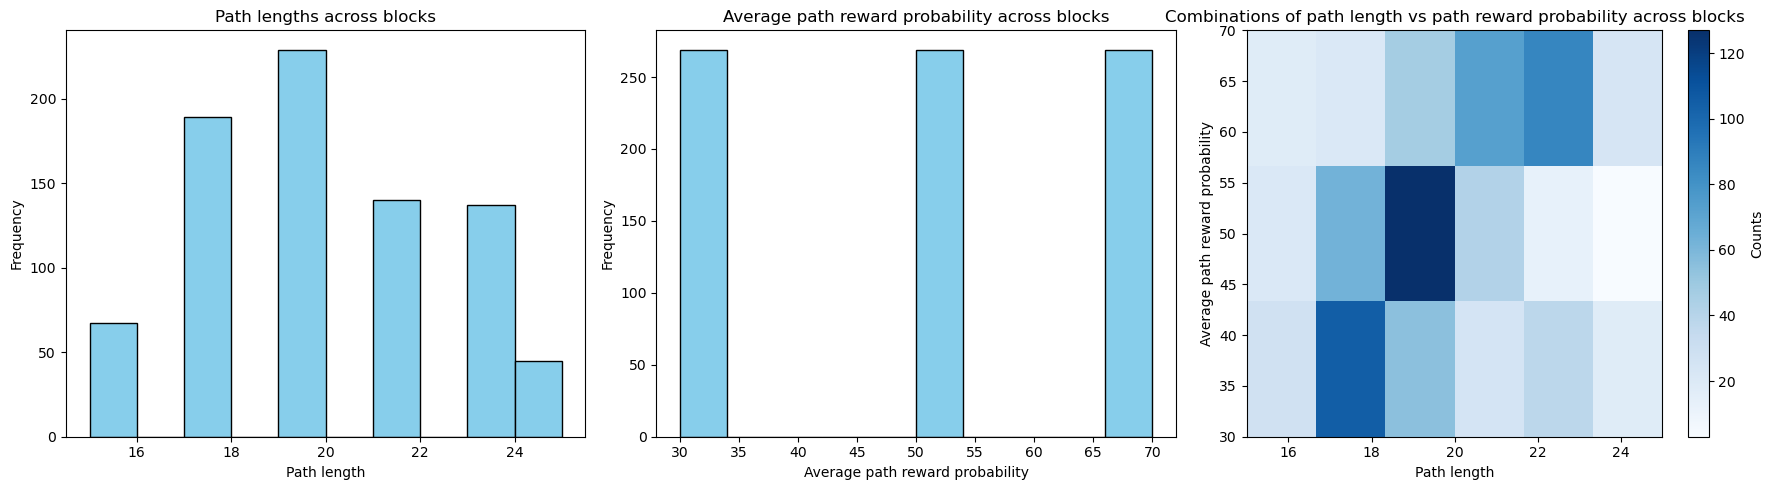

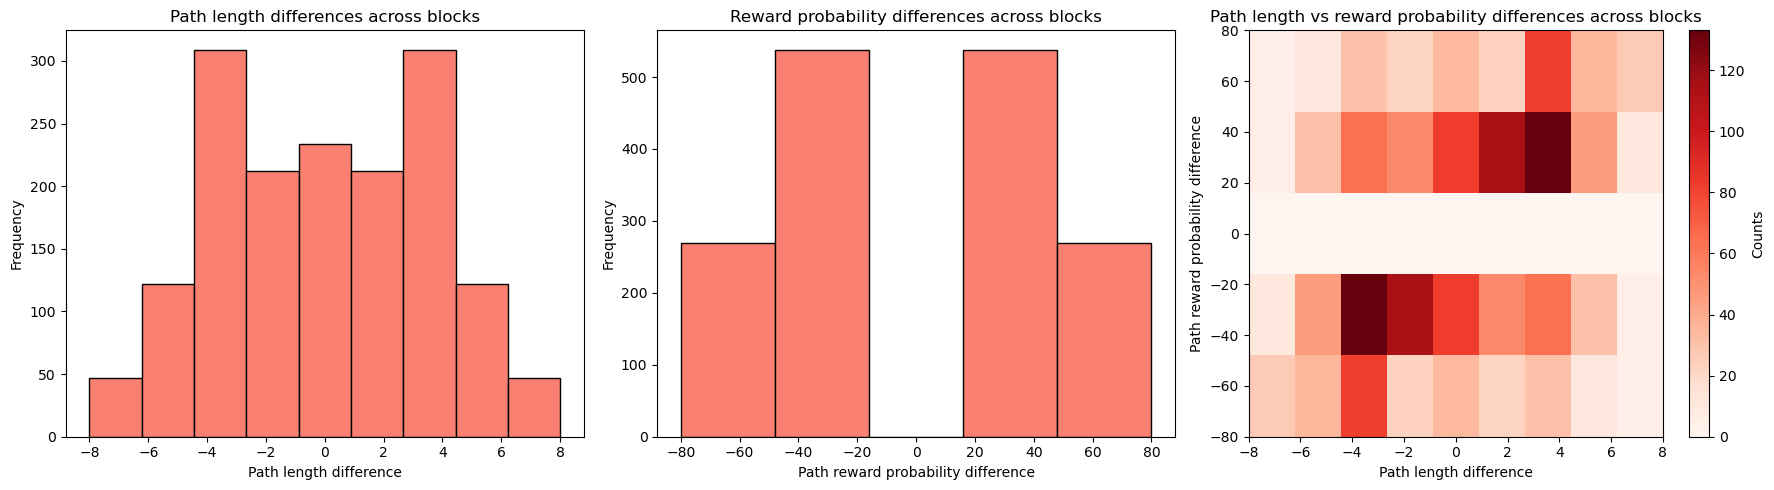

In [5]:
from hexmaze import get_reward_path_lengths

subject_id = "Toby"

# Get all blocks for this rat
subject_block_df = pd.DataFrame((HexMazeBlock() * Session()).fetch(as_dict=True))
subject_block_df = subject_block_df[subject_block_df["subject_id"] == subject_id]
# display(subject_block_df)

# Store all combinations of reward prob and path length
combinations = []

# Also store reward prob and path length differences
diffs = []

for i, row in subject_block_df.iterrows():
    maze = row["config_id"]
    len_ab, len_ac, len_bc = get_reward_path_lengths(maze)
    pa, pb, pc = row["p_a"], row["p_b"], row["p_c"]
    prob_ab, prob_ac, prob_bc = (pa + pb) / 2, (pa + pc) / 2, (pb + pc) / 2

    combinations.append({"path_length": len_ab, "avg_path_prob": prob_ab})
    combinations.append({"path_length": len_ac, "avg_path_prob": prob_ac})
    combinations.append({"path_length": len_bc, "avg_path_prob": prob_bc})

    diffs.append({"path_length_diff": len_ab - len_ac, "path_prob_diff": pb - pc})
    diffs.append({"path_length_diff": len_ac - len_ab, "path_prob_diff": pc - pb})
    diffs.append({"path_length_diff": len_ab - len_bc, "path_prob_diff": pa - pc})
    diffs.append({"path_length_diff": len_bc - len_ab, "path_prob_diff": pc - pa})
    diffs.append({"path_length_diff": len_ac - len_bc, "path_prob_diff": pa - pb})
    diffs.append({"path_length_diff": len_bc - len_ac, "path_prob_diff": pb - pa})

combinations_df = pd.DataFrame(combinations)
display(combinations_df)

diff_df = pd.DataFrame(diffs)
display(diff_df)

# Plot a histogram of all combinations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Path lengths
axes[0].hist(combinations_df["path_length"], color="skyblue", edgecolor="black")
axes[0].set_xlabel("Path length")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Path lengths across blocks")
# Avg path reward prob
axes[1].hist(combinations_df["avg_path_prob"], color="skyblue", edgecolor="black")
axes[1].set_xlabel("Average path reward probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Average path reward probability across blocks")
# Both
h = axes[2].hist2d(
    combinations_df["path_length"],
    combinations_df["avg_path_prob"],
    bins=[6, 3],
    cmap="Blues",
)
fig.colorbar(h[3], ax=axes[2], label="Counts")
axes[2].set_xlabel("Path length")
axes[2].set_ylabel("Average path reward probability")
axes[2].set_title(
    "Combinations of path length vs path reward probability across blocks"
)
plt.tight_layout()
plt.show()

# Plot a histogram of all diffs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Path length differences
axes[0].hist(diff_df["path_length_diff"], color="salmon", bins=9, edgecolor="black")
axes[0].set_xlabel("Path length difference")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Path length differences across blocks")
# Path probability differences
axes[1].hist(diff_df["path_prob_diff"], color="salmon", bins=5, edgecolor="black")
axes[1].set_xlabel("Path reward probability difference")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Reward probability differences across blocks")
# Both
h = axes[2].hist2d(
    diff_df["path_length_diff"], diff_df["path_prob_diff"], bins=[9, 5], cmap="Reds"
)
fig.colorbar(h[3], ax=axes[2], label="Counts")
axes[2].set_xlabel("Path length difference")
axes[2].set_ylabel("Path reward probability difference")
axes[2].set_title("Path length vs reward probability differences across blocks")
plt.tight_layout()
plt.show()